### Cab-Driver Agent

>> - Sanjaya Kumar Sahu
>> - Adarsh Vittal Shetty

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
# from keras import layers
import tensorflow
import tensorflow.keras.models
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Activation,Flatten
from tensorflow.keras.optimizers import Adam
import tempfile


# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [2]:
# Used the below patch to aid pickle to serialize the keras model 
# reference:  http://zachmoshe.com/2017/04/03/pickling-keras-models.html
# This helped in storing the model as a pickle file

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=False) as fd:
            tensorflow.keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=False) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = tensorflow.keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = tensorflow.keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

In [3]:
make_keras_picklable()

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [5]:
print("Max ride duration",Time_matrix.max())
print("Min ride duration",Time_matrix.min())

Max ride duration 11.0
Min ride duration 0.0


## Observation:
Maximum ride duration for any pick up and drop location is 11 hours, which means that maximum day update won't be more than 1

#### Tracking the state-action pairs for checking convergence


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.91
        self.learning_rate = 0.01
        ## Here the epsilon is initialized, this value will change for each episode based on the epsilon decay
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0009
        self.epsilon_min = 0.0001        

        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # To track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0, 0, 0])).reshape(1, 36)
        # Initialize the value of the states tracked
        self.states_tracked = []

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()

        # Write your code here: Add layers to your neural nets   
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def get_action(self, possible_actions_index, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment  
        """ Choose action according to ε-greedy policy. We generate a random number over [0, 1) from uniform distribution.
           If the generated number is less than ε, we will explore, otherwise we will exploit the policy by choosing the
           action which has maximum Q-value.
        """       
        if np.random.rand() <= self.epsilon:
            # exploration: choose a random action from possible ride requests
            return random.choice(possible_actions_index)
        else:
            # Exploatation: choose the action with the highest q(s, a)           
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # predict the Q_values using the model
            q_value = self.model.predict(state)

            # list of Q- values for the possible action.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]


    def append_sample(self, state, action, reward, next_state,terminal_state):
        # Write your code here:      
        # save sample <s,a,r,s'> to the replay memory
        # pick samples randomly from replay memory (with batch_size) and train the network
        self.memory.append((state, action, reward, next_state,terminal_state))

    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            # iterate through batch and update the target values
            for i in range(self.batch_size):
                # Terminal state.
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:  # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # fit the model
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tracking.
        q_value = self.model.predict(self.track_state)

        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as f:
            pickle.dump(agent.model, f, pickle.HIGHEST_PROTOCOL)


In [7]:
episode_time = 24*30 #24 hrs * 30 days after which car has to be recharged
Episodes = 3000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(state_size,action_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


### DQN block

In [8]:
start_time = time.time()
score_tracked = []
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init
    total_time = 0  # Total time driver rode in this episod
    
    while not terminal_state:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(possible_actions_indices,state)

        # 3. Evaluate your reward and next state        
        next_state, reward,step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            terminal_state = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state,terminal_state)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = agent.epsilon_min+(agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # print episode,reward,memorylength, epsilon and time taken ,every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode:", episode, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
        
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    #Saving the model every 100 episodes
    if (episode % 100 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
               
time_taken = time.time() - start_time
print("Time Taken : ",time_taken, "seconds")

      

Saving Model 0
episode: 9   score: -99.0   memory length: 1397   epsilon: 0.9919335233339106
episode: 19   score: -520.0   memory length: 2000   epsilon: 0.9830470706444826
episode: 29   score: -96.0   memory length: 2000   epsilon: 0.9742402372052044
episode: 39   score: -361.0   memory length: 2000   epsilon: 0.9655123096577525
episode: 49   score: -161.0   memory length: 2000   epsilon: 0.9568625810352235
episode: 59   score: -93.0   memory length: 2000   epsilon: 0.9482903507048697
episode: 69   score: 19.0   memory length: 2000   epsilon: 0.9397949243113475
episode: 79   score: -444.0   memory length: 2000   epsilon: 0.9313756137204741
episode: 89   score: 59.0   memory length: 2000   epsilon: 0.9230317369634883
episode: 99   score: -120.0   memory length: 2000   epsilon: 0.9147626181818109
Saving Model 100
episode: 109   score: 28.0   memory length: 2000   epsilon: 0.9065675875722993
episode: 119   score: 315.0   memory length: 2000   epsilon: 0.8984459813329936
episode: 129   sc

episode: 1019   score: 1276.0   memory length: 2000   epsilon: 0.39973645605494584
episode: 1029   score: 1000.0   memory length: 2000   epsilon: 0.39615586478014647
episode: 1039   score: 1238.0   memory length: 2000   epsilon: 0.3926073542469384
episode: 1049   score: 752.0   memory length: 2000   epsilon: 0.38909063702402824
episode: 1059   score: 1039.0   memory length: 2000   epsilon: 0.3856054282553982
episode: 1069   score: 977.0   memory length: 2000   epsilon: 0.3821514456372326
episode: 1079   score: 965.0   memory length: 2000   epsilon: 0.37872840939505076
episode: 1089   score: 1297.0   memory length: 2000   epsilon: 0.37533604226104555
episode: 1099   score: 1256.0   memory length: 2000   epsilon: 0.37197406945162437
Saving Model 1100
episode: 1109   score: 1000.0   memory length: 2000   epsilon: 0.36864221864515145
episode: 1119   score: 1348.0   memory length: 2000   epsilon: 0.3653402199598898
episode: 1129   score: 963.0   memory length: 2000   epsilon: 0.362067805932

episode: 1999   score: 1490.0   memory length: 2000   epsilon: 0.16553117941470533
Saving Model 2000
episode: 2009   score: 1841.0   memory length: 2000   epsilon: 0.16404897870799443
episode: 2019   score: 1200.0   memory length: 2000   epsilon: 0.16258005795819824
episode: 2029   score: 1217.0   memory length: 2000   epsilon: 0.16112429818193286
episode: 2039   score: 1710.0   memory length: 2000   epsilon: 0.1596815814618605
episode: 2049   score: 1862.0   memory length: 2000   epsilon: 0.15825179093713806
episode: 2059   score: 1707.0   memory length: 2000   epsilon: 0.1568348107939512
episode: 2069   score: 1468.0   memory length: 2000   epsilon: 0.15543052625613366
episode: 2079   score: 1288.0   memory length: 2000   epsilon: 0.15403882357587004
episode: 2089   score: 1733.0   memory length: 2000   epsilon: 0.15265959002448237
episode: 2099   score: 1166.0   memory length: 2000   epsilon: 0.15129271388329882
Saving Model 2100
episode: 2109   score: 1369.0   memory length: 2000  

episode: 2969   score: 1889.0   memory length: 2000   epsilon: 0.06920003753569541
episode: 2979   score: 1547.0   memory length: 2000   epsilon: 0.06858092737259606
episode: 2989   score: 1467.0   memory length: 2000   epsilon: 0.06796736420205594
episode: 2999   score: 1586.0   memory length: 2000   epsilon: 0.06735929832512275
Time Taken :  32366.124237537384 seconds


### Save the model

In [9]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [10]:
agent.states_tracked

[167.71458,
 197.10846,
 140.26492,
 141.95695,
 152.02812,
 215.3999,
 255.94649,
 267.1803,
 301.69434,
 323.60748,
 247.06342,
 246.1314,
 233.98376,
 300.56427,
 258.75375,
 349.49722,
 314.12134,
 269.93207,
 275.69702,
 331.26193,
 316.52603,
 331.10226,
 311.92078,
 331.60242,
 331.9334,
 294.14413,
 288.04526,
 288.2616,
 301.26984,
 321.72513,
 315.54147,
 292.54886,
 299.32047,
 314.83087,
 310.49774,
 285.47556,
 323.89044,
 317.80682,
 273.2137,
 382.1282,
 329.6891,
 315.37753,
 351.20868,
 311.0185,
 321.47708,
 321.76382,
 324.60764,
 347.3222,
 295.81537,
 333.6141,
 331.43918,
 279.18915,
 279.10812,
 343.29092,
 304.5309,
 330.60837,
 325.64673,
 349.73294,
 327.16403,
 297.66763,
 308.21222,
 343.0493,
 315.6388,
 318.23752,
 338.24695,
 331.00958,
 308.80664,
 331.55612,
 315.29495,
 320.23828,
 373.09314,
 323.33807,
 330.4339,
 304.9147,
 321.6057,
 315.91916,
 329.27914,
 299.12842,
 309.68182,
 339.79602,
 318.18362,
 308.01108,
 303.04752,
 339.66556,
 348.8854

In [11]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

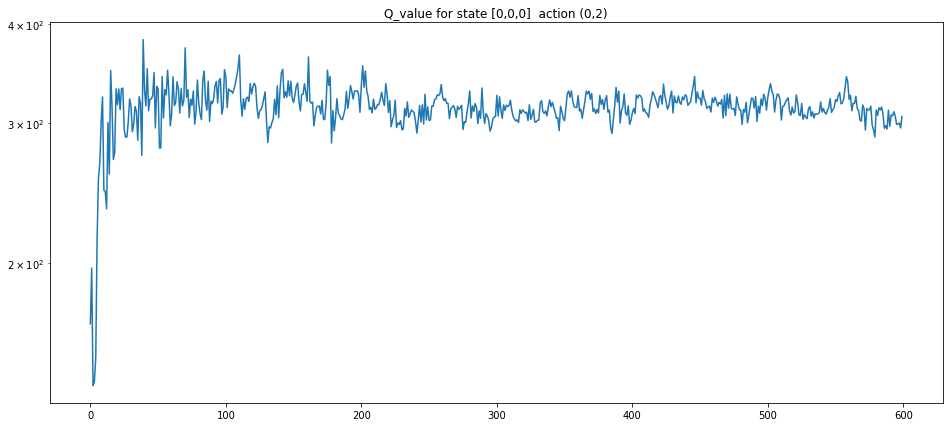

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [13]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

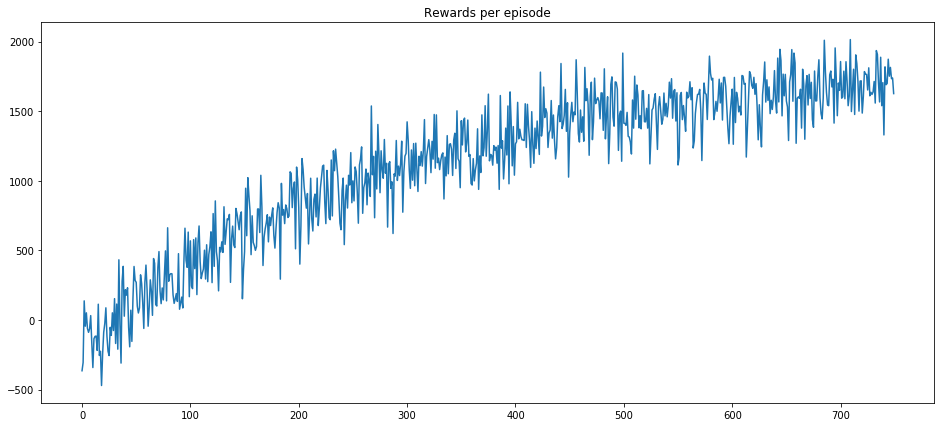

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [15]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0.001 + (1 - 0.001) * np.exp(-0.0009*i))

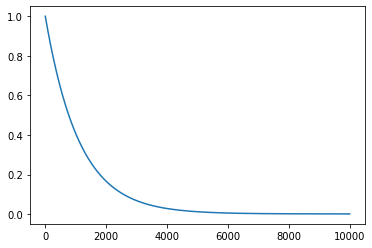

In [16]:
plt.plot(time, epsilon)
plt.show()